<a href="https://colab.research.google.com/github/mfilipak/FILIPAK-DATA-SCIENCE/blob/main/DIA5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AULA 05 - GERADORES E AUGMENTATION


### PARTE 1 - Carregar um modelo pré-treinado para classificação IMAGENET

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from glob import glob
import random
import cv2

# Carregar o modelo MobileNetV2 pré-treinado na ImageNet
model = MobileNetV2(weights='imagenet')



### PARTE 2 - Carregar um dataset com imagens de fogo e não fogo (https://github.com/cair/Fire-Detection-Image-Dataset)

In [2]:
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Fire%20images.rar?raw=true' -O fire_images.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%201.rar?raw=true' -O non_fire_images_01.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%202.rar?raw=true' -O non_fire_images_02.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%203.rar?raw=true' -O non_fire_images_03.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%204.rar?raw=true' -O non_fire_images_04.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%205.rar?raw=true' -O non_fire_images_05.rar
clear_output()


In [3]:
!unrar x fire_images.rar /content/fire/ -y
!unrar x non_fire_images_01.rar /content/nonfire/ -y
!unrar x non_fire_images_02.rar /content/nonfire/ -y
!unrar x non_fire_images_03.rar /content/nonfire/ -y
!unrar x non_fire_images_04.rar /content/nonfire/ -y
!unrar x non_fire_images_05.rar /content/nonfire/ -y
clear_output()


In [6]:
fire_list = sorted(glob("./fire/**/*.*", recursive=True))
nonfire_list = sorted(glob("./nonfire/**/*.*", recursive=True))
print(len(fire_list), len(nonfire_list))

110 541


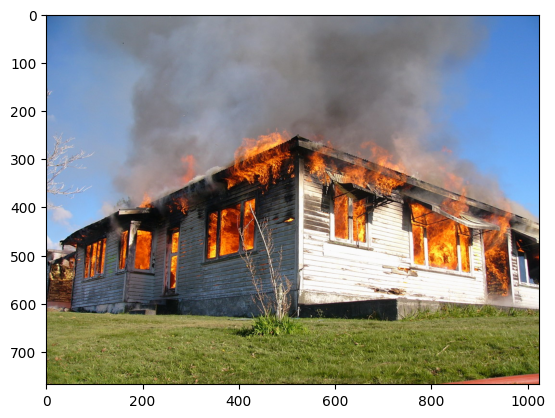

In [7]:
for f in fire_list[15:16]:
  img = cv2.imread(f)[...,::-1]
  plt.imshow(img)
  plt.show()

### PARTE 3 - Prediçoes do modelo pré-treinado

[('n04330267', 'stove', 0.52258104), ('n03347037', 'fire_screen', 0.16754998), ('n04111531', 'rotisserie', 0.04532519)]


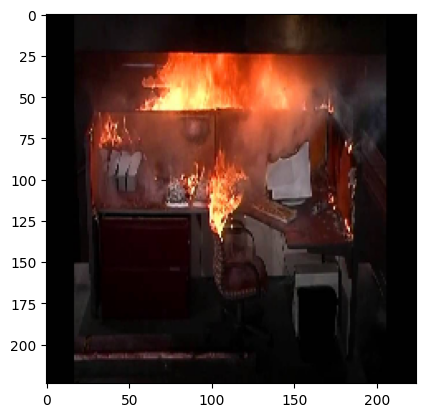

[('n09472597', 'volcano', 0.07209791), ('n04467665', 'trailer_truck', 0.045871664), ('n02965783', 'car_mirror', 0.03757767)]


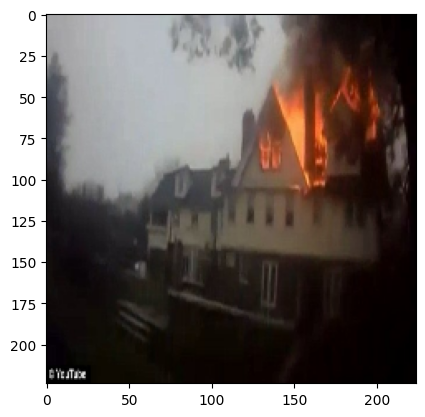

[('n03788365', 'mosquito_net', 0.13826986), ('n03791053', 'motor_scooter', 0.04192206), ('n03347037', 'fire_screen', 0.034903627)]


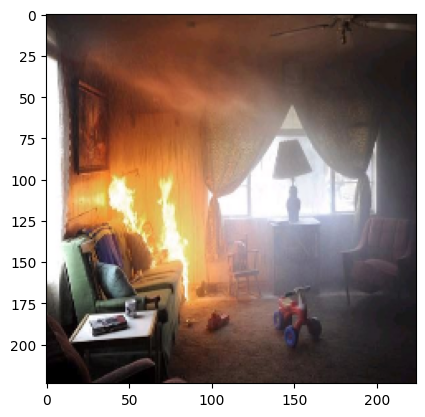

[('n03388549', 'four-poster', 0.4360783), ('n04590129', 'window_shade', 0.08789941), ('n04344873', 'studio_couch', 0.061137356)]


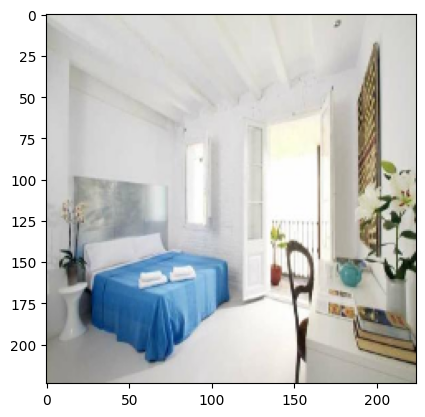

[('n04335435', 'streetcar', 0.14568117), ('n04509417', 'unicycle', 0.06818237), ('n02930766', 'cab', 0.052483972)]


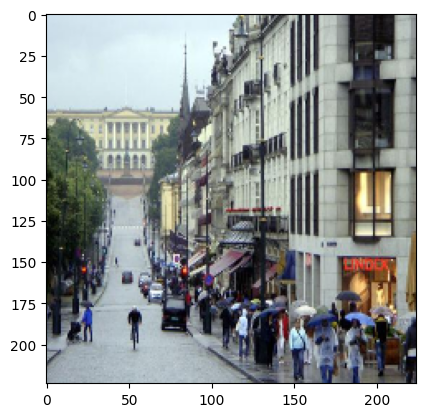

[('n03529860', 'home_theater', 0.99136716), ('n04344873', 'studio_couch', 0.001222453), ('n03032252', 'cinema', 0.00086913485)]


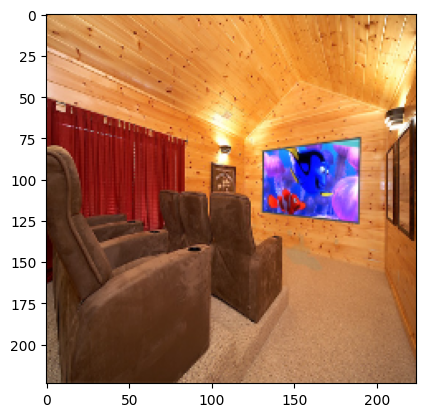

In [28]:
random.seed(42)
for f in random.sample(fire_list,3)+random.sample(nonfire_list,3):
  img = cv2.resize(cv2.imread(f)[...,::-1],(224,224))
  x = (2*(img[None,...]/255)-1).astype("float32") #Normalização min=-1,max=1
  y = model.predict(x, verbose=False)


  print(decode_predictions(y,top=3)[0])
  plt.imshow(img)
  plt.show()

In [ ]:
#preds = model.predict(preprocess_input(img)[None,...], verbose=False)
#print('Predicted:', decode_predictions(preds, top=3)[0])

### PARTE 4 - Extrai do modelo MOBILENET o submodelo do "vetor latente"

In [32]:
model.layers[-5:], model.layers[-2]

([<keras.src.layers.convolutional.conv2d.Conv2D at 0x792e5e64ace0>,
 <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D at 0x792e5e4918d0>)

In [37]:
submodel = Model(inputs=model.input, outputs=model.layers[-2].output)

In [40]:
submodel.layers[-5:], submodel.output_shape

([<keras.src.layers.normalization.batch_normalization.BatchNormalization at 0x792e5e4905b0>,
 (None, 1280))

In [41]:
submodel.predict(x)

1/1 [==============================] - 1s 892ms/step


array([[1.6784042 , 0.        , 0.09952475, ..., 0.7771137 , 1.5312333 ,
        0.09626906]], dtype=float32)

# AUGMENTATIONS

In [44]:
import albumentations as A

In [68]:
img = cv2.imread(nonfire_list[0])[...,::-1]

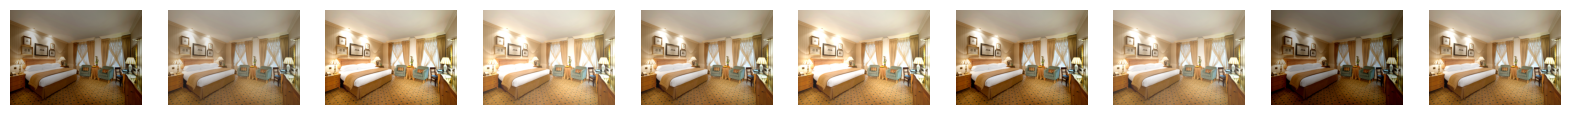

In [73]:
plt.figure(figsize=(20,5))
for i in range(10):
  plt.subplot(1,10,i+1), plt.axis("off")
  plt.imshow(A.RandomBrightnessContrast(p=1)(image=img)["image"])

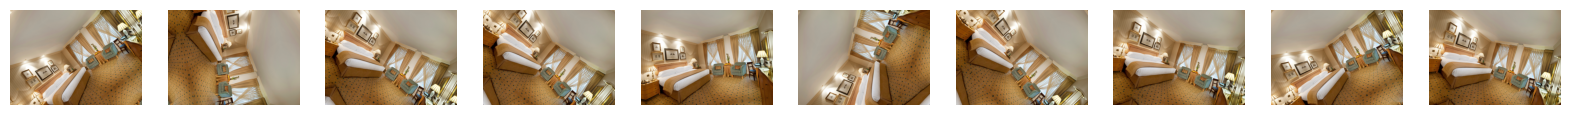

In [74]:
plt.figure(figsize=(20,5))
for i in range(10):
  plt.subplot(1,10,i+1), plt.axis("off")
  plt.imshow(A.Rotate(p=1)(image=img)["image"])
plt.show()

In [76]:
transform = A.Compose(
    [ A.RandomBrightnessContrast(p=1),
    A.Rotate(p=1),
    A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1),
    A.Resize(224,224)
    ]
)

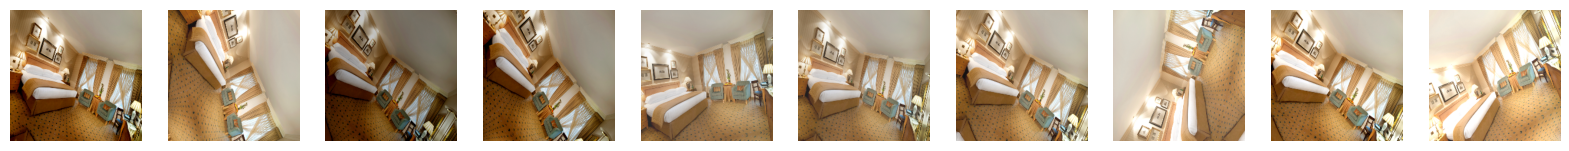

In [78]:
plt.figure(figsize=(20,5))
for i in range(10):
  plt.subplot(1,10,i+1), plt.axis("off")
  plt.imshow(transform(image=img)["image"])
plt.show()